In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

seed = 71
np.random.seed = seed
algorithm_globals.random_seed = seed

In [2]:
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, SLSQP

n = 3
mu = 2**(n-1)
sigma = 1
number_of_training_sample = 1000
real_data = np.random.normal(mu, sigma, size=number_of_training_sample)
discritised_real_data = np.round(real_data)

num_qubits = [n]
bounds = [0, 2**n-1]
num_epochs = 300
batch_size = 100


qgan = QGAN(discritised_real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed)

# Set entangler map

# Set an initial state for the generator circuit as a uniform distribution
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement='linear', reps=2)

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/var/folders/d1/7ljpg1_d429bsgwdcxv9yr340000gn/T/ipykernel_24895/679059037.py:26: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


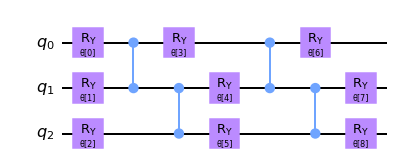

In [3]:
ansatz.decompose().draw('mpl')

In [4]:
# Run qGAN for "number_of_trial" runs and find the best trial with the minimum relative entropy
result_set = {}
number_of_trial = 10
for trial in range(number_of_trial):
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
    result = qgan.run(quantum_instance)
    result_set[trial] = [result['params_g'], result['rel_entr']]
    print(trial, result['rel_entr'])
    trial += 1
    
minimum_relative_entropy_trial = 0
for trial in range(number_of_trial):
    if(result_set[trial][1] < result_set[minimum_relative_entropy_trial][1]): 
        minimum_relative_entropy_trial = trial    

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=result_set[minimum_relative_entropy_trial][0])
result = qgan.run(quantum_instance)

0 1.1725
1 2.5229
2 3.8214
3 0.9737
4 0.964
5 2.987
6 1.0492
7 1.9863
8 2.0151
9 0.3703


In [5]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [ 0.15748734  0.5202935   0.27575387 ... -0.16018839 -0.04400483
  0.00855084]
  params_g : [5.34391727 2.16183594 0.37328221 0.46666747 5.32013954 5.8376663
 5.13503934 1.89288353 0.85743093]
  loss_d : 0.693
  loss_g : [0.6865]
  rel_entr : 0.369


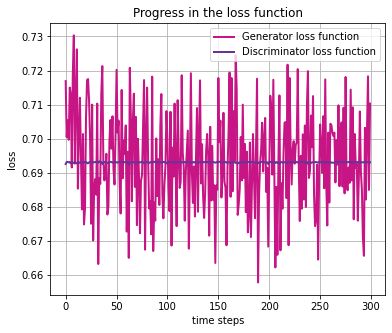

In [14]:
# Plot progress w.r.t the generator's and the discriminator's loss function
initial = num_epochs*minimum_relative_entropy_trial
final = num_epochs*(minimum_relative_entropy_trial+1)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss[initial:final], label="Generator loss function", color="mediumvioletred", linewidth=2)
plt.plot(t_steps, qgan.d_loss[initial:final], label="Discriminator loss function", color="rebeccapurple", linewidth=2)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

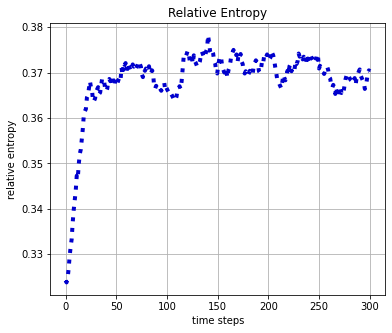

In [10]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr[initial:final])), qgan.rel_entr[initial:final], color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

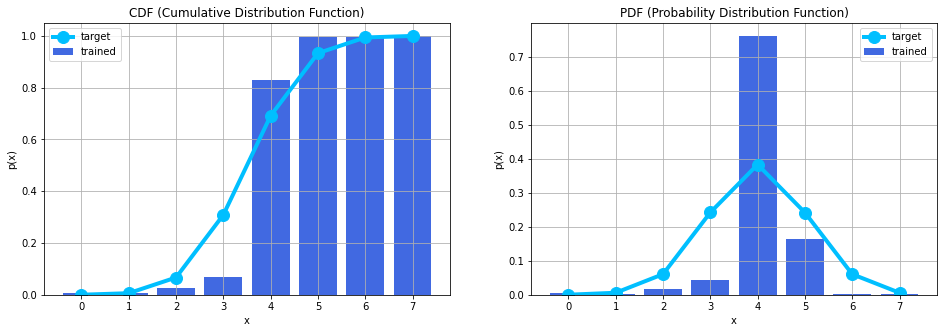

In [15]:
# # Plot the CDF of the resulting distribution against the target distribution, i.e. log-gaussian
gaussian = np.random.normal(mu, sigma, size=10000000)
gaussian = np.round(gaussian)
# print(gaussian, len(gaussian))
gaussian = gaussian[gaussian >= bounds[0]]
gaussian = gaussian[gaussian <= bounds[1]]
# print(gaussian, len(gaussian))
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(gaussian == i)]
gaussian = np.array(temp / sum(temp))
# print(gaussian, len(gaussian))

# data_gaussian = np.random.gaussian(mu, sigma, size=10000000)
# # data_gaussian = np.round(data_gaussian)
# data_gaussian = data_gaussian[data_gaussian >= bounds[0]]
# data_gaussian = data_gaussian[data_gaussian <= bounds[1]]
# # print(data_gaussian)
# # getting data of the histogram
# count, bins_count = np.histogram(data_gaussian, bins=bounds[1]+1)
# pdf = count / sum(count)
# cdf = np.cumsum(pdf)


plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.title("CDF (Cumulative Distribution Function)")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g, np.cumsum(prob_g), color="royalblue", width=0.8, label="trained")
plt.plot(np.cumsum(gaussian), "-o", label="target", color="deepskyblue", linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g) + 1, 1.0))
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title('PDF (Probability Distribution Function)')
plt.bar(samples_g,  prob_g, color='royalblue', width=0.8, label='trained')
plt.plot((gaussian), '-o', label='target', color='deepskyblue', linewidth=4, markersize=12)
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")
plt.show()
